In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [ ]:
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load Dataset

In [ ]:
img_size = 128

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

dataset = datasets.CelebA(root='celeba/', split="train", target_type='attr', download=True, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

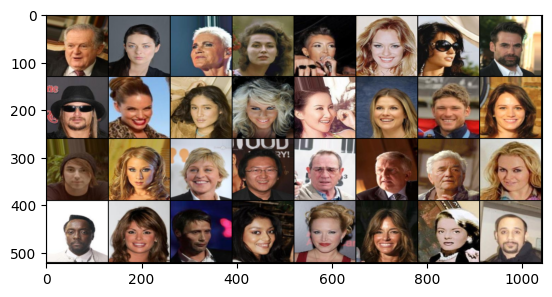

In [4]:
from matplotlib import pyplot as plt
x, y = next(iter(train_dataloader))

grid = make_grid(x, normalize=True, scale_each=False)
plt.imshow(grid.permute(1, 2, 0).numpy())

# Conditional Model w/ Diffusers

In [15]:
from diffusers import DDPMScheduler, UNet2DModel

device = "cuda" if torch.cuda.is_available() else "cpu"

logging.info("Using device: {}".format(device))

class ClassConditionedUnet(nn.Module):
    def __init__(self, class_attr_dim=40, class_emb_size=5, img_size=128):
        super().__init__()
        
        self.class_emb = nn.Linear(class_attr_dim, class_emb_size)
        
        self.model = UNet2DModel(
            sample_size=img_size, # Image resolution
            in_channels=3+class_emb_size,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(64, 128, 256, 512),
            down_block_types=(
                "DownBlock2D",        # a regular ResNet downsampling block
                "AttnDownBlock2D",    # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
                "AttnDownBlock2D"
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "AttnUpBlock2D",      # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",          # a regular ResNet upsampling block
            ),
        )
        
    def forward(self, x, t, class_attr):
        bs, ch, w, h = x.shape
        
        logging.info(f"X: {x.device}, t: {t.device}, class_attr: {class_attr.device}")
        
        class_cond = self.class_emb(class_attr.float()) # Shape (batch, 5)
        
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Shape (batch, 5, img_size, img_size)
        
        net_input = torch.cat([x, class_cond], dim=1) # Shape (batch, 8, img_size, img_size)
        
        return self.model(net_input, t).sample

2025-05-08 14:00:13,512 - INFO - Using device: cuda


# Training / Sampling

In [6]:
from accelerate import Accelerator

accelerator = Accelerator()

In [16]:
n_epochs = 10

diffusion_model = ClassConditionedUnet(class_attr_dim=40, class_emb_size=5, img_size=128)

trainable_params = sum(
    p.numel() for p in diffusion_model.parameters() if p.requires_grad
)

print("total no.of parameters in unet model = ", trainable_params)

total no.of parameters in unet model =  63485840


In [8]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=1e-3)

In [17]:
train_dataloader, diffusion_model, noise_scheduler, optimizer = accelerator.prepare(
    train_dataloader,
    diffusion_model,
    noise_scheduler,
    optimizer
)

## Core Training Loop

In [19]:
loss_fn = nn.MSELoss()

losses = []

for epoch in range(n_epochs):
    for x,y in tqdm(train_dataloader):
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device) # Generate timestep for each batch
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        pred = diffusion_model(noisy_x, timesteps, y)
        
        loss = loss_fn(pred, noise)
        
        # Backprop
        optimizer.zero_grad()
        accelerator.backward(loss)
        optimizer.step()
        
        losses.append(loss.item())
    
    avg_loss = sum(losses) / len(losses)
    print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")
    torch.save(diffusion_model.state_dict(), f"./diffusion_outputs/model_epoch_{epoch+1}_ckpt.pth")
    
plt.plot(losses)

  0%|          | 0/1272 [00:07<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 24.00 GiB of which 0 bytes is free. Of the allocated memory 23.03 GiB is allocated by PyTorch, and 147.65 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Old

In [4]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_embed_dim=None):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.norm2 = nn.GroupNorm(8, out_channels)
        
        self.act = nn.SiLU()
        
        if time_embed_dim is not None:
            self.time_mlp = nn.Linear(time_embed_dim, out_channels)
        
    def forward(self, x, time_emb=None):
        h = self.act(self.norm1(self.conv1(x)))
        
        if self.time_embed_dim is not None and time_emb is not None:
            time_emb = self.act(self.time_mlp(time_emb))
            h = h + time_emb.unsqueeze(-1).unsqueeze(-1)
            
        h = self.act(self.norm2(self.conv2(h)))
        return h

In [5]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [6]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=128, features=[64, 128, 256, 512]):
        super().__init__()
        self.time_dim = time_dim
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, features[0], kernel_size=3, padding=1)
        
        # Encoder pathway
        self.downs = nn.ModuleList()
        for i in range(len(features) - 1):
            self.downs.append(nn.ModuleList([
                Block(features[i], features[i], time_dim),
                Block(features[i], features[i+1], time_dim),
                nn.MaxPool2d(kernel_size=2)
            ]))
            
        # Middle blocks
        self.middle = nn.ModuleList([
            Block(features[-1], features[-1], time_dim),
            Block(features[-1], features[-1], time_dim)
        ])
        
        # Decoder pathway
        self.ups = nn.ModuleList()
        for i in reversed(range(len(features) - 1)):
            self.ups.append(nn.ModuleList([
                Block(features[i+1], features[i+1], time_dim),
                Block(features[i+1], features[i], time_dim),
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
            ]))
            
        # Final convolution
        self.final_conv = nn.Sequential(
            Block(features[0], features[0], time_dim),
            nn.Conv2d(features[0], out_channels, kernel_size=1)
        )
        
    def forward(self, x, t):
        # Time embedding
        t = self.time_mlp(t)
        
        # Initial convolution
        x = self.init_conv(x)
        
        # Store residual connections
        residuals = []
        
        # Encoder
        for down_block1, down_block2, downsample in self.downs:
            x = down_block1(x, t)
            x = down_block2(x, t)
            residuals.append(x)
            x = downsample(x)
            
        # Middle
        x = self.middle[0](x, t)
        x = self.middle[1](x, t)
        
        # Decoder
        for up_block1, up_block2, upsample in self.ups:
            x = up_block1(x, t)
            x = up_block2(x, t)
            x = upsample(x)
            residual = residuals.pop()
            
            # Handle potential size mismatch
            if x.shape != residual.shape:
                x = F.interpolate(x, size=residual.shape[2:], mode="bilinear", align_corners=False)
                
            x = x + residual  # Skip connection
            
        # Final convolution
        return self.final_conv(x)

In [17]:
def extract(a, t, x_shape):
    """Extract coefficients at specified timesteps t and reshape to match x_shape"""
    batch_size = t.shape[0]
    out = a.to(t.device).gather(-1, t)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [8]:
class DiffusionModel:
    def __init__(self, device, num_timesteps=500, beta_start=1e-4, beta_end=0.02):
        self.device = device
        self.num_timesteps = num_timesteps
        
        # Define beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        # Define alphas
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Pre-calculate diffusion parameters
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1. / self.alphas)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion process"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        sqrt_alphas_cumprod_t = extract(self.sqrt_alphas_cumprod, t, x_start.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    def p_losses(self, denoise_model, x_start, t, noise=None):
        """Calculate training loss for the denoising model"""
        if noise is None:
            noise = torch.randn_like(x_start)
            
        # Add noise to the input image according to timestep t
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        
        # Predict the noise using the model
        predicted_noise = denoise_model(x_noisy, t)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)
        return loss

    @torch.no_grad()
    def p_sample(self, model, x, t, t_index):
        """Sample from the model at timestep t"""
        betas_t = extract(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(self.sqrt_recip_alphas, t, x.shape)
        
        # Equation 11 in the paper
        # Use model to predict the mean
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        )
        
        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = extract(self.posterior_variance, t, x.shape)
            noise = torch.randn_like(x)
            # Algorithm 2 in the paper
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def p_sample_loop(self, model, shape):
        """Generate samples from the model using the sampling loop"""
        device = next(model.parameters()).device
        b = shape[0]
        
        # Start from pure noise
        img = torch.randn(shape, device=device)
        
        # Progressively denoise the image
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='Sampling timesteps', total=self.num_timesteps):
            # Create a batch of the same timestep
            t = torch.full((b,), i, device=device, dtype=torch.long)
            # Sample from p(x_{t-1} | x_t)
            img = self.p_sample(model, img, t, i)
            
        # Samples are in [-1, 1] range
        return img

    @torch.no_grad()
    def sample(self, model, batch_size=16, channels=3, img_size=64):
        """Simple interface for sampling from the model"""
        return self.p_sample_loop(model, shape=(batch_size, channels, img_size, img_size))

In [15]:
def train_diffusion(diffusion, model, dataloader, optimizer, num_epochs=10, device="cpu"):
    """Train the diffusion model"""
    os.makedirs("diffusion_outputs", exist_ok=True)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
        
        for i, batch in progress_bar:
            # print(len(batch))
            # print(type(batch))
            # print(batch.shape)
            images = batch
            
            
            images = images.to(device)
            optimizer.zero_grad()
            
            # Sample random timesteps
            t = torch.randint(0, diffusion.num_timesteps, (images.shape[0],), device=device).long()
            
            # Calculate loss
            loss = diffusion.p_losses(model, images, t)
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/(i+1))
            
        # Save checkpoint
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }
        torch.save(checkpoint, f"diffusion_outputs/checkpoint_epoch_{epoch+1}.pt")
            
        # Generate and save samples
        if (epoch + 1) % 2 == 0 or epoch == num_epochs - 1:
            model.eval()
            sample_images = diffusion.sample(model, batch_size=4, img_size=64)
            # Rescale from [-1, 1] to [0, 1]
            sample_images = (sample_images + 1) / 2
            save_image(sample_images, f"diffusion_outputs/samples_epoch_{epoch+1}.png", nrow=2)
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}")
    
    # Save the final model
    torch.save(model.state_dict(), "diffusion_outputs/final_model.pt")

Image batch shape: torch.Size([32, 3, 512, 512])
attr shape: torch.Size([32, 40])


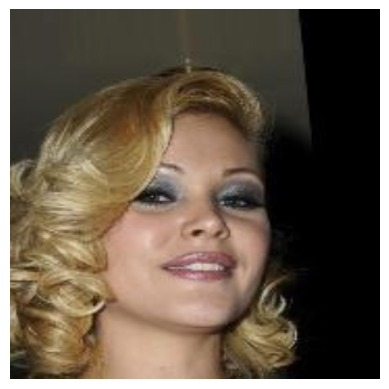

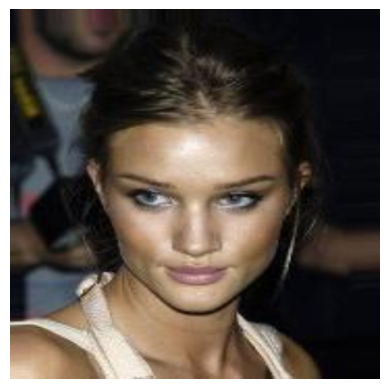

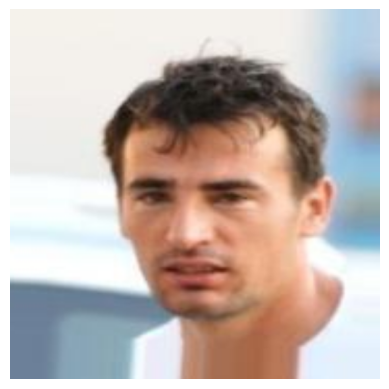

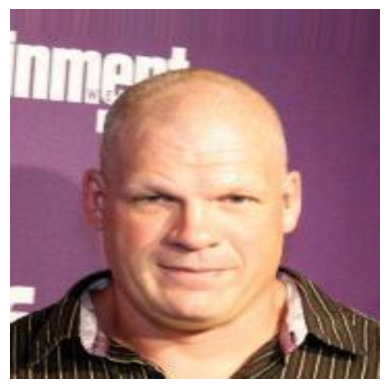

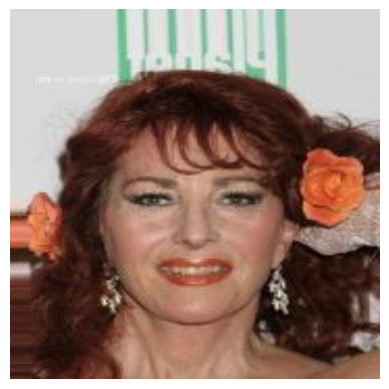

In [20]:
test_dataloader = get_celeba_dataloader(
    root_dir='./celeba',
    split='train',
    batch_size=32,
    image_size=512,
    target_types=['attr'],
    return_dict=True
)

for images, targets in test_dataloader:
        print(f"Image batch shape: {images.shape}")
        if isinstance(targets, dict):
            for target_type, target_tensor in targets.items():
                print(f"{target_type} shape: {target_tensor.shape}")
        else:
            print(f"Target shape: {targets.shape}")
        break

# Show the first 5 images in the batch 'images'
from matplotlib import pyplot as plt
imgs = images[:5]

for img in imgs:
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    img = (img + 1) / 2  # Rescale to [0, 1]
    img = img.numpy()
    # img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()  # Move plt.show() outside the loop to display all images at once

In [10]:
def generate_images(model, diffusion, output_dir, total_images=10000, batch_size=16, device="cpu"):
    """Generate a large number of images efficiently"""
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    
    num_batches = (total_images + batch_size - 1) // batch_size
    image_count = 0
    
    for batch_idx in tqdm(range(num_batches), desc="Generating batches"):
        # For the last batch, adjust batch size if needed
        current_batch_size = min(batch_size, total_images - image_count)
        
        # Generate a batch of images
        with torch.no_grad():
            batch_images = diffusion.sample(model, batch_size=current_batch_size, img_size=64)
            # Rescale from [-1, 1] to [0, 1]
            batch_images = (batch_images + 1) / 2
            
            # Save as a grid for inspection
            if batch_idx % 10 == 0:
                save_image(batch_images, os.path.join(output_dir, f"grid_{batch_idx}.png"), nrow=4)
            
            # Save individual images
            for i in range(current_batch_size):
                filename = os.path.join(output_dir, f"img_{image_count:05d}.png")
                save_image(batch_images[i], filename)
                image_count += 1
                
                if image_count >= total_images:
                    break

In [11]:
import logging

def main():
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create output directories
    os.makedirs("diffusion_outputs", exist_ok=True)
    os.makedirs("diffusion_outputs/generated", exist_ok=True)
    
    # Dataset preparation
    transform = transforms.Compose([
        transforms.CenterCrop(160),
        transforms.Resize(64),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    # Load dataset
    # try:
    #     image_dir = "celebA/celeba/img_align_celeba"
    #     dataset = datasets.ImageFolder(root=image_dir, transform=transform)
    #     dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    #     print(f"Loaded dataset with {len(dataset)} images")
    # except Exception as e:
    #     # print(f"Error loading dataset: {e}")
    #     logging.error(f"Error loading dataset: {e}", exc_info=True, stack_info=True)
    #     print("Make sure the CelebA dataset is available at the specified path")
    #     return
    
    dataloader = get_celeba_dataloader(
        root_dir='./celeba',
        split='train',
        batch_size=32,
        image_size=64,
        return_dict=True
    )
    
    # Initialize model
    model = SimpleUNet(in_channels=3, out_channels=3, time_dim=128).to(device)
    
    # Initialize diffusion process (using fewer timesteps for a more practical demonstration)
    diffusion = DiffusionModel(device=device, num_timesteps=500)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Train model
    print("Starting training...")
    train_diffusion(diffusion, model, dataloader, optimizer, num_epochs=10, device=device)
    
    # Generate images
    print("Generating 10,000 images...")
    generate_images(model, diffusion, "diffusion_outputs/generated", total_images=10000, batch_size=16, device=device)
    
    print("Done! 10,000 images saved in: diffusion_outputs/generated")

In [18]:
main()

Using device: cuda
Starting training...


Epoch 1/10:   0%|          | 0/5087 [00:00<?, ?it/s]Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2ac1f6e7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2ac1f6e7a0><function _MultiProcessingDataLoaderIter.__del__ at 0x7f2ac1f6e7a0>
Exception ignored in: 

Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f2ac1f6e7a0>Traceback (most recent call last):
  File "/home/sawyer/01_classwork/genVision-celebA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
  File "/home/sawyer/01_classwork/genVision-celebA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__

  File "/home/sawyer/01_classwork/genVision-celebA/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
Traceback (most recent call last):
            self._shutdow

RuntimeError: The size of tensor a (256) must match the size of tensor b (512) at non-singleton dimension 1

In [15]:
import os

os.getcwd()

'/home/sawyer/01_classwork/genVision-celebA'

In [16]:
from pathlib import Path

test_img_dir = Path("celebA/celeba/img_align_celeba")
test_img_dir.exists()

True